In [1]:
import os
import random
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.preprocessing import image
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [2]:
# Set random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Question 1. Generate dataset with combined images

In [3]:
# Load the MNIST dataset and normalize pixel values to [0, 1]
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Concatenate training and testing datasets
X = np.concatenate((x_train, x_test), axis=0)  # Combine images
y = np.concatenate((y_train, y_test), axis=0)  # Combine labels

# Split into 70% training, 15% validation, and 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [4]:
def create_combined_samples(x, y, num_samples):
    """
    Randomly combine two MNIST images side by side and compute their sum as the label.

    Args:
        x (numpy.ndarray): Array of MNIST images (shape: [num_total_samples, 28, 28]).
        y (numpy.ndarray): Array of MNIST labels (shape: [num_total_samples]).
        num_samples (int): Number of combined samples to generate.

    Returns:
        combined_images (numpy.ndarray): Horizontally stacked image array (shape: [num_samples, 28, 56]).
        combined_labels (numpy.ndarray): Sum of labels array (shape: [num_samples]).
        y_2labels (numpy.ndarray): Array of label pairs (shape: [num_samples, 2]).
    """
    x = np.array(x)
    y = np.array(y)
    num_total = len(y)

    # Randomly generate indices for the image pairs
    idx1 = np.random.randint(0, num_total, size=num_samples)
    idx2 = np.random.randint(0, num_total, size=num_samples)

    # Retrieve the corresponding images and labels
    img1 = x[idx1]  # Shape: [num_samples, 28, 28]
    img2 = x[idx2]  # Shape: [num_samples, 28, 28]

    label1 = y[idx1]  # Shape: [num_samples]
    label2 = y[idx2]  # Shape: [num_samples]

    # Vertically concatenate images
    combined_images = np.hstack((img1, img2))  # Shape: [num_samples, 56, 28]

    # Compute the sum of the labels
    combined_labels = label1 + label2  # Shape: [num_samples]

    # label1: upper image, label2: lower image
    y_2labels = np.stack((label1, label2), axis=1)  # Shape: [num_samples, 2]

    return combined_images, combined_labels,  y_2labels


# Generate combined training dataset
X_train_tmp, y_train_tmp, y_train_2labels = create_combined_samples(X_train, y_train, 400000)

# Generate combined validation dataset
X_val_tmp, y_val_tmp, y_val_2labels = create_combined_samples(X_val, y_val, 150000)

# Generate combined test dataset
X_test_tmp, y_test_tmp, y_test_2labels = create_combined_samples(X_test, y_test, 150000)


In [5]:
def balance_samples(images, labels, y_2labels, num_samples_per_class):
    """
    Extracts a balanced subset of samples from the dataset, ensuring each class has the same number of samples.

    Args:
        images (numpy.ndarray): Array of images (shape: [num_total_samples, height, width]).
        labels (numpy.ndarray): Array of labels (shape: [num_total_samples]).
        num_samples_per_class (int): Number of samples to extract per class.

    Returns:
        balanced_images (numpy.ndarray): Balanced subset of images (shape: [num_samples_per_class * num_classes, height, width]).
        balanced_labels (numpy.ndarray): Balanced subset of labels (shape: [num_samples_per_class * num_classes]).
    """
    # Identify unique classes
    classes = np.unique(labels)
    
    # Initialize lists to store balanced images and labels
    balanced_images = []
    balanced_labels = []
    balanced_y_2labels = []

    for cls in classes:
        # Find indices of samples belonging to the current class
        cls_indices = np.where(labels == cls)[0]
        
        # Check if there are enough samples in the class
        if len(cls_indices) < num_samples_per_class:
            print(len(cls_indices))
            print(num_samples_per_class)
            raise ValueError(f"Not enough samples for class {cls} to extract {num_samples_per_class} samples.")
        
        # Randomly select the specified number of samples without replacement
        selected_indices = np.random.choice(cls_indices, size=num_samples_per_class, replace=False)
        
        # Append the selected images and labels to the lists
        balanced_images.append(images[selected_indices])
        balanced_labels.append(labels[selected_indices])
        balanced_y_2labels.append(y_2labels[selected_indices])

    # Concatenate all balanced samples into single arrays
    balanced_images = np.vstack(balanced_images)
    balanced_labels = np.hstack(balanced_labels)
    balanced_y_2labels = np.vstack(balanced_y_2labels)

    return balanced_images, balanced_labels, balanced_y_2labels

In [6]:
def random_sample(images, labels, y_2labels, num_samples):
    """
    Randomly samples a subset of the dataset without considering class balance.

    Args:
        images (numpy.ndarray): Array of images (shape: [num_total_samples, height, width]).
        labels (numpy.ndarray): Array of labels (shape: [num_total_samples]).
        num_samples (int): Number of samples to extract.

    Returns:
        sampled_images (numpy.ndarray): Randomly sampled images (shape: [num_samples, height, width]).
        sampled_labels (numpy.ndarray): Randomly sampled labels (shape: [num_samples]).
    """
    # Check if num_samples is less than or equal to the total number of samples
    if num_samples > len(labels):
        raise ValueError("num_samples exceeds the total number of samples in the dataset.")
    
    # Randomly select indices without replacement
    selected_indices = np.random.choice(len(labels), size=num_samples, replace=False)
    
    # Extract the samples
    sampled_images = images[selected_indices]
    sampled_labels = labels[selected_indices]
    sampled_y_2labels = y_2labels[selected_indices]
    
    return sampled_images, sampled_labels, sampled_y_2labels


In [7]:
num_samples_per_class_train = 3500  
num_samples_per_class_val = 1000   
num_samples_per_class_test = 1000

num_unique_labels = len(np.unique(y_train_tmp)) 

train_size = num_samples_per_class_train * num_unique_labels
val_size = num_samples_per_class_val * num_unique_labels
test_size = num_samples_per_class_test * num_unique_labels

# Generate imbalanced datasets
X_train_inbal, y_train_inbal, y_train_2labels_inbal = random_sample(X_train_tmp, y_train_tmp, y_train_2labels, train_size)
X_val_inbal, y_val_inbal, y_val_2labels_inbal = random_sample(X_val_tmp, y_val_tmp, y_val_2labels, val_size)
X_test_inbal, y_test_inbal, y_test_2labels_inbal = random_sample(X_test_tmp, y_test_tmp, y_test_2labels, test_size)

# Generate balanced datasets
X_train_bal, y_train_bal, y_train_2labels_bal = balance_samples(X_train_tmp, y_train_tmp, y_train_2labels, num_samples_per_class_train)
X_val_bal, y_val_bal, y_val_2labels_bal = balance_samples(X_val_tmp, y_val_tmp, y_val_2labels, num_samples_per_class_val)
X_test_bal, y_test_bal, y_test_2labels_bal = balance_samples(X_test_tmp, y_test_tmp, y_test_2labels, num_samples_per_class_test)

In [8]:
def preprocess_dataset(images, labels, num_classes=19):
    """
    Flattens the images and one-hot encodes the labels.

    Args:
        images (numpy.ndarray): Array of images (shape: [num_samples, height, width]).
        labels (numpy.ndarray): Array of labels (shape: [num_samples]).
        num_classes (int): Number of unique classes.

    Returns:
        X_flat (numpy.ndarray): Flattened images (shape: [num_samples, height * width]).
        y_oh (numpy.ndarray): One-hot encoded labels (shape: [num_samples, num_classes]).
    """
    # Flatten the images
    X_flat = images.reshape(images.shape[0], -1)
    
    # One-hot encode the labels
    y_oh = to_categorical(labels, num_classes=num_classes)
    
    return X_flat, y_oh

X_train_bal_flat, y_train_bal_oh = preprocess_dataset(X_train_bal, y_train_bal, num_classes=19)
X_val_bal_flat, y_val_bal_oh = preprocess_dataset(X_val_bal, y_val_bal, num_classes=19)
X_test_bal_flat, y_test_bal_oh = preprocess_dataset(X_test_bal, y_test_bal, num_classes=19)

X_train_inbal_flat, y_train_inbal_oh = preprocess_dataset(X_train_inbal, y_train_inbal, num_classes=19)
X_val_inbal_flat, y_val_inbal_oh = preprocess_dataset(X_val_inbal, y_val_inbal, num_classes=19)
X_test_inbal_flat, y_test_inbal_oh = preprocess_dataset(X_test_inbal, y_test_inbal, num_classes=19)

print(f"Balanced Training set: images shape = {X_train_bal_flat.shape}, labels shape = {y_train_bal_oh.shape}")
print(f"Balanced Validation set: images shape = {X_val_bal_flat.shape}, labels shape = {y_val_bal_oh.shape}")
print(f"Balanced Test set: images shape = {X_test_bal_flat.shape}, labels shape = {y_test_bal_oh.shape}")
print()
print(f"Inbalanced Training set: images shape = {X_train_inbal_flat.shape}, labels shape = {y_train_inbal_oh.shape}")
print(f"Inbalanced Validation set: images shape = {X_val_inbal_flat.shape}, labels shape = {y_val_inbal_oh.shape}")
print(f"Inbalanced Test set: images shape = {X_test_inbal_flat.shape}, labels shape = {y_test_inbal_oh.shape}")

Balanced Training set: images shape = (66500, 1568), labels shape = (66500, 19)
Balanced Validation set: images shape = (19000, 1568), labels shape = (19000, 19)
Balanced Test set: images shape = (19000, 1568), labels shape = (19000, 19)

Inbalanced Training set: images shape = (66500, 1568), labels shape = (66500, 19)
Inbalanced Validation set: images shape = (19000, 1568), labels shape = (19000, 19)
Inbalanced Test set: images shape = (19000, 1568), labels shape = (19000, 19)


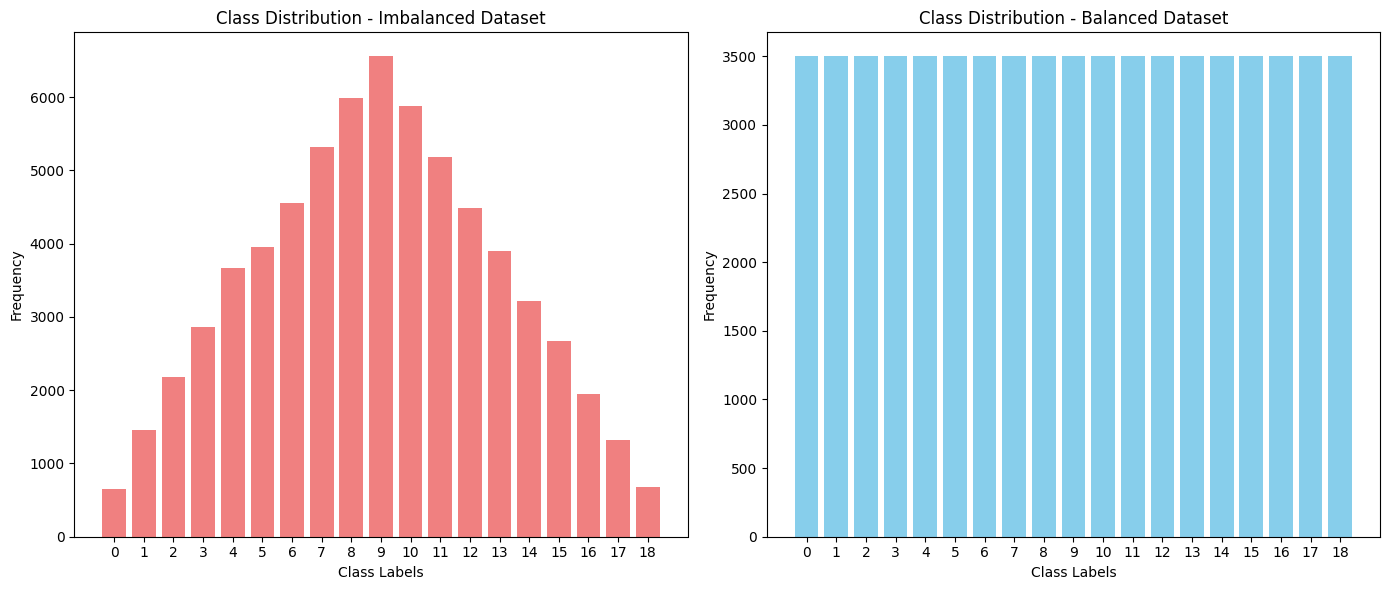

In [9]:
# plot the class distribution of the balanced and imbalanced datasets

# Count the frequency of each class in the balanced and imbalanced datasets
unique_bal, counts_bal = np.unique(y_train_bal, return_counts=True)
unique_inbal, counts_inbal = np.unique(y_train_inbal, return_counts=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(unique_inbal, counts_inbal, color='lightcoral')
axes[0].set_title('Class Distribution - Imbalanced Dataset')
axes[0].set_xlabel('Class Labels')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(unique_inbal)
axes[0].set_xticklabels(unique_inbal)

axes[1].bar(unique_bal, counts_bal, color='skyblue')
axes[1].set_title('Class Distribution - Balanced Dataset')
axes[1].set_xlabel('Class Labels')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(unique_bal)
axes[1].set_xticklabels(unique_bal)

plt.tight_layout()
plt.show()

#### Dataset Generation Process
Initially, two different dataset strategies were explored:

1. **Imbalanced Dataset**:  This method results in an imbalanced dataset, where the majority of class sums are concentrated around the middle (near 9), with fewer examples from extreme values (e.g., class 0 and class 18). 

2. **Balanced Dataset**: To counteract the potential bias(later we will see models trained on imbalanced dataset is more robust) introduced by the imbalanced dataset, a balanced dataset was generated, ensuring an equal number of samples for each class. This was achieved by selecting examples from the imbalanced dataset.

#### Dataset Splits
- **Training Set**: 3500 images, representing a diverse set of paired images for robust model learning.
- **Validation Set**: 1000 images, used to tune model parameters and assess the model's performance during training.
- **Test Set**: 1000 images, serving as an unbiased dataset to evaluate the model’s generalization capability.

Both datasets (imbalanced and balanced) were treated equally in terms of the number of images for training, validation, and test sets to control for external variables during model evaluation.

#### Statistical Properties
- **Balanced vs. Imbalanced Approach**: The **balanced dataset** was selected from a pool of **imbalanced datasets** to ensure that each class had sufficient representation, especially for classes like 0 and 18, which would otherwise be underrepresented.
- **Random Pairing and Label Generation**: The images were paired randomly to avoid any unintended biases, ensuring a diverse set of class sums in the dataset. 


## Question 2. Hyperparameter tuning for Fully-Connected Networks

In [10]:
# Build model for hyperparameter tuning

def build_model(hp):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(X_train_bal_flat.shape[1],)))
    
    # Hyperparameters for hidden layers
    for i in range(hp.Int('num_hidden_layers', 2, 4)):  # Number of hidden layers 
        units = hp.Choice('units_' + str(i), values=[ 32, 64, 128])  # Number of neurons per layer
        activation = hp.Choice('activation_' + str(i), values=['relu', 'sigmoid', 'tanh'])  # Activation function
        model.add(layers.Dense(units, activation=activation))  # Add Dense layer with hyperparameterized activation
        dropout_rate = hp.Choice('dropout_rate_' + str(i), values=[0.1, 0.15, 0.2])  # Dropout rate
        model.add(layers.Dropout(dropout_rate))  # Add Dropout layer
    
    model.add(layers.Dense(19, activation='softmax')) # Output layer for classification (19 classes, softmax activation)
    
    # Hyperparameter for learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    
    # Compile the model with the selected learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [11]:
# hyperparameter tuning for balanced dataset
# to conduct hyperparameter tuning again, change the `project_name`` to a new name, some performance metrics may change
# WARNING: It would take 60-90 minutes to run the hyperparameter tuning

num_models = 20  # Number of hyperparameter combinations to try
num_epochs = 50  # Number of epochs to train each model

tuner_bal = kt.RandomSearch( # Initialize the Keras Tuner for balanced data
    build_model,
    objective='val_accuracy',
    max_trials=num_models,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='fcn_tuning_bal',
    project_name='mnist_addition_classification_bal' # project_name='mnist_addition_classification_bal'
)


# tuner_bal.search_space_summary() # Display the search space summary

early_stop_bal = EarlyStopping( # Define Early Stopping callback for balanced data
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Run the hyperparameter search on the balanced dataset
tuner_bal.search(
    X_train_bal_flat, y_train_bal_oh,
    epochs=num_epochs,
    validation_data=(X_val_bal_flat, y_val_bal_oh),
    callbacks=[early_stop_bal],
    verbose=1
)

# tuner_bal.results_summary() # Display tuner results for balanced data

best_hps_bal = tuner_bal.get_best_hyperparameters(num_trials=num_models) # Retrieve all trial hyperparameters for balanced data

os.makedirs('balanced_models', exist_ok=True) # directory to save balanced models

all_models_bal = tuner_bal.get_best_models(num_models=num_models) # Retrieve and save all trial models for balanced data


# # It's only useful for the first time to save the models, no need to run it again
# os.makedirs('balanced_models_v2', exist_ok=True)
# for i, model in enumerate(all_models_bal, start=1):
#     model_filename_bal = f'balanced_models/model_trial_bal_{i}.h5'  # Save in 'balanced_models' folder
#     model.save(model_filename_bal)
# print(f"All models saved")



Reloading Tuner from fcn_tuning_bal\mnist_addition_classification_bal\tuner0.json


In [12]:
tuner_bal.results_summary()

Results summary
Results in fcn_tuning_bal\mnist_addition_classification_bal
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 11 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 128
activation_0: sigmoid
dropout_rate_0: 0.2
units_1: 64
activation_1: relu
dropout_rate_1: 0.1
learning_rate: 0.001
units_2: 32
activation_2: tanh
dropout_rate_2: 0.2
units_3: 64
activation_3: sigmoid
dropout_rate_3: 0.2
Score: 0.8999473452568054

Trial 02 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 128
activation_0: relu
dropout_rate_0: 0.2
units_1: 64
activation_1: relu
dropout_rate_1: 0.1
learning_rate: 0.001
units_2: 32
activation_2: tanh
dropout_rate_2: 0.2
units_3: 64
activation_3: tanh
dropout_rate_3: 0.2
Score: 0.899052619934082

Trial 03 summary
Hyperparameters:
num_hidden_layers: 4
units_0: 128
activation_0: sigmoid
dropout_rate_0: 0.1
units_1: 128
activation_1: sigmoid
dropout_rate_1: 0.15
learning_rate: 0.0001
units_2: 128
activation_2: relu
dropout_rat

In [13]:
# # WARNING: This cell takes between 60-90 minutes to run
# # Train same 20 hyperparameter combination on imbalanced dataset

# # Create directory to save imbalanced models
# os.makedirs('imbalanced_models', exist_ok=True)

# # Define Early Stopping callback for imbalanced data
# early_stop_inbal = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# # Iterate through each hyperparameter set to train on imbalanced data
# for i, hps in enumerate(best_hps_bal, start=1):
#     # Build the model with the current hyperparameters
#     model_inbal = tuner_bal.hypermodel.build(hps)
    
#     # Train the model on imbalanced data
#     model_inbal.fit(
#         X_train_inbal_flat, y_train_inbal_oh,
#         epochs=num_epochs,
#         validation_data=(X_val_inbal_flat, y_val_inbal_oh),
#         callbacks=[early_stop_inbal],
#         verbose=1
#     )
    
#     # Save the trained imbalanced model
#     model_filename_inbal = f'imbalanced_models/model_trial_inbal_{i}.h5'  # Save in 'imbalanced_models' folder
#     model_inbal.save(model_filename_inbal)
#     print(f"Saved imbalanced model {i} to {model_filename_inbal}")

In [14]:
# Evaluate the models trained form balanced and imbalanced data on balanced and imbalanced validation datasets, save the results to a JSON file

# Define paths to the two directories
folder_balanced = 'balanced_models'
folder_imbalanced = 'imbalanced_models'

# Get sorted file lists for both directories
balanced_model_files = sorted(os.listdir(folder_balanced))
imbalanced_model_files = sorted(os.listdir(folder_imbalanced))

# Ensure both folders have the same number of models
if len(balanced_model_files) != len(imbalanced_model_files):
    raise ValueError("The number of models in the two folders does not match!")

evaluation_results = {
    'balanced_model': {
        'balanced_test': {'loss': [], 'accuracy': []},
        'imbalanced_test': {'loss': [], 'accuracy': []}
    },
    'imbalanced_model': {
        'balanced_test': {'loss': [], 'accuracy': []},
        'imbalanced_test': {'loss': [], 'accuracy': []}
    }
}

print("Evaluating models...\n")
for bal_file, inbal_file in zip(balanced_model_files, imbalanced_model_files):
    # Load balanced and imbalanced models
    bal_model_path = os.path.join(folder_balanced, bal_file)
    inbal_model_path = os.path.join(folder_imbalanced, inbal_file)
    bal_model = load_model(bal_model_path)
    inbal_model = load_model(inbal_model_path)
    
    # Evaluate balanced model on balanced test set and imbalanced test set
    bal_test_loss_bal, bal_test_accuracy_bal = bal_model.evaluate(X_test_bal_flat, y_test_bal_oh, verbose=0)
    bal_test_loss_inbal, bal_test_accuracy_inbal = bal_model.evaluate(X_test_inbal_flat, y_test_inbal_oh, verbose=0)
    
    # Evaluate imbalanced model on balanced test set and imbalanced test set
    inbal_test_loss_bal, inbal_test_accuracy_bal = inbal_model.evaluate(X_test_bal_flat, y_test_bal_oh, verbose=0)
    inbal_test_loss_inbal, inbal_test_accuracy_inbal = inbal_model.evaluate(X_test_inbal_flat, y_test_inbal_oh, verbose=0)
    
    # Store the evaluation results in the dictionary
    evaluation_results['balanced_model']['balanced_test']['loss'].append(bal_test_loss_bal)
    evaluation_results['balanced_model']['balanced_test']['accuracy'].append(bal_test_accuracy_bal)
    evaluation_results['balanced_model']['imbalanced_test']['loss'].append(bal_test_loss_inbal)
    evaluation_results['balanced_model']['imbalanced_test']['accuracy'].append(bal_test_accuracy_inbal)
    evaluation_results['imbalanced_model']['balanced_test']['loss'].append(inbal_test_loss_bal)
    evaluation_results['imbalanced_model']['balanced_test']['accuracy'].append(inbal_test_accuracy_bal)
    evaluation_results['imbalanced_model']['imbalanced_test']['loss'].append(inbal_test_loss_inbal)
    evaluation_results['imbalanced_model']['imbalanced_test']['accuracy'].append(inbal_test_accuracy_inbal)
    
    # Print the evaluation results for the current pair of models
    print(f"Balanced Model on Balanced Test - Loss: {bal_test_loss_bal:.4f}, Accuracy: {bal_test_accuracy_bal:.4f}")
    print(f"Balanced Model on Imbalanced Test - Loss: {bal_test_loss_inbal:.4f}, Accuracy: {bal_test_accuracy_inbal:.4f}")
    print(f"Imbalanced Model on Balanced Test - Loss: {inbal_test_loss_bal:.4f}, Accuracy: {inbal_test_accuracy_bal:.4f}")
    print(f"Imbalanced Model on Imbalanced Test - Loss: {inbal_test_loss_inbal:.4f}, Accuracy: {inbal_test_accuracy_inbal:.4f}")
    print()

results_folder = 'performance_results'
os.makedirs(results_folder, exist_ok=True)

# Save the evaluation results to a JSON file in the new folder
fcn_results_file_path = os.path.join(results_folder, 'evaluation_results.json')
with open(fcn_results_file_path, 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print(f"Evaluation completed and results saved to '{fcn_results_file_path}'.")

Evaluating models...

Balanced Model on Balanced Test - Loss: 0.4373, Accuracy: 0.8899
Balanced Model on Imbalanced Test - Loss: 0.4901, Accuracy: 0.8750
Imbalanced Model on Balanced Test - Loss: 0.4510, Accuracy: 0.8857
Imbalanced Model on Imbalanced Test - Loss: 0.4293, Accuracy: 0.8883

Balanced Model on Balanced Test - Loss: 0.8419, Accuracy: 0.7568
Balanced Model on Imbalanced Test - Loss: 1.0000, Accuracy: 0.7060
Imbalanced Model on Balanced Test - Loss: 0.8952, Accuracy: 0.7478
Imbalanced Model on Imbalanced Test - Loss: 0.9224, Accuracy: 0.7304

Balanced Model on Balanced Test - Loss: 1.0648, Accuracy: 0.6843
Balanced Model on Imbalanced Test - Loss: 1.2953, Accuracy: 0.5997
Imbalanced Model on Balanced Test - Loss: 1.1034, Accuracy: 0.6818
Imbalanced Model on Imbalanced Test - Loss: 1.1768, Accuracy: 0.6515

Balanced Model on Balanced Test - Loss: 1.1719, Accuracy: 0.6460
Balanced Model on Imbalanced Test - Loss: 1.4217, Accuracy: 0.5529
Imbalanced Model on Balanced Test - Los

hidden table of accuracy, uncomment to see

<!-- | Model Index | Balanced Model on Balanced Test Accuracy | Balanced Model on Imbalanced Test Accuracy | Imbalanced Model on Balanced Test Accuracy | Imbalanced Model on Imbalanced Test Accuracy |
|-------------|------------------------------------------|--------------------------------------------|--------------------------------------------|----------------------------------------------|
| 1           | 0.8962                                   | 0.8790                                     | 0.8923                                     | 0.8938                                       |
| 2           | 0.7576                                   | 0.7152                                     | 0.7421                                     | 0.7326                                       |
| 3           | 0.6855                                   | 0.6110                                     | 0.6827                                     | 0.6593                                       |
| 4           | 0.6496                                   | 0.5661                                     | 0.6437                                     | 0.6158                                       |
| 5           | 0.6098                                   | 0.5119                                     | 0.6358                                     | 0.6015                                       |
| 6           | 0.6038                                   | 0.5016                                     | 0.6144                                     | 0.5932                                       |
| 7           | 0.5559                                   | 0.4463                                     | 0.5353                                     | 0.5317                                       |
| 8           | 0.5505                                   | 0.4442                                     | 0.5218                                     | 0.4809                                       |
| 9           | 0.4285                                   | 0.3105                                     | 0.3201                                     | 0.3062                                       |
| 10          | 0.3596                                   | 0.2486                                     | 0.2193                                     | 0.2359                                       |
| 11          | 0.3332                                   | 0.2322                                     | 0.2129                                     | 0.2263                                       |
| 12          | 0.8945                                   | 0.8814                                     | 0.8955                                     | 0.8935                                       |
| 13          | 0.3124                                   | 0.2063                                     | 0.1663                                     | 0.2107                                       |
| 14          | 0.8857                                   | 0.8710                                     | 0.8786                                     | 0.8809                                       |
| 15          | 0.8874                                   | 0.8701                                     | 0.8720                                     | 0.8758                                       |
| 16          | 0.8741                                   | 0.8598                                     | 0.8686                                     | 0.8619                                       |
| 17          | 0.8694                                   | 0.8493                                     | 0.8595                                     | 0.8592                                       |
| 18          | 0.8486                                   | 0.8209                                     | 0.8451                                     | 0.8442                                       |
| 19          | 0.8454                                   | 0.8178                                     | 0.8297                                     | 0.8213                                       |
| 20          | 0.8273                                   | 0.7974                                     | 0.8168                                     | 0.8082                                       | -->


In [15]:
# plot the performance of the model on the balanced/imbalanced test for each class

# folder_balanced = 'balanced_models'
# folder_imbalanced = 'imbalanced_models'

# # Get sorted file lists for both directories
# balanced_model_files = sorted(os.listdir(folder_balanced))
# imbalanced_model_files = sorted(os.listdir(folder_imbalanced))
class_labels = list(range(19))

def generate_classification_report(model_type, model_index, X_test, y_test, class_labels):
    """
    Generate and save a classification report for a specified model.

    Parameters:
        model_type (str): 'balanced' or 'imbalanced' to specify which type of model to load.
        model_index (int): The index of the model to load (1-based indexing).
        X_test (ndarray): Test data.
        y_test (ndarray): True labels for the test data (one-hot encoded).
        class_labels (list): List of class labels for the report.
    
    Returns:
        report_df (DataFrame): DataFrame containing classification metrics for each class.
    """
    # Load the specified model
    if model_type == 'balanced':
        model_path = os.path.join(folder_balanced, balanced_model_files[model_index - 1])
    elif model_type == 'imbalanced':
        model_path = os.path.join(folder_imbalanced, imbalanced_model_files[model_index - 1])
    else:
        raise ValueError("Invalid model type. Use 'balanced' or 'imbalanced'.")

    model = load_model(model_path)

    # Predict the labels
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Generate classification report
    report = classification_report(y_true_classes, y_pred_classes, labels=class_labels, target_names=[f"Class {i}" for i in class_labels], output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Save the report to a CSV file
    # report_filename = f"{model_type}_model_{model_index}_classification_report.csv"
    # report_df.to_csv(report_filename, index=True)
    # print(f"Saved classification report to {report_filename}")

    return report_df

def plot_classification_metrics(report_df, model_type, model_index):
    """
    Plot precision, recall, and f1-score for each class using Seaborn.

    Parameters:
        report_df (DataFrame): DataFrame containing classification metrics for each class.
        model_type (str): 'balanced' or 'imbalanced'.
        model_index (int): The index of the model.
    """
    # Exclude 'accuracy', 'macro avg', and 'weighted avg' rows
    metrics_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

    # Melt the DataFrame for Seaborn
    metrics_melted = metrics_df.reset_index().melt(id_vars='index', value_vars=['precision', 'recall', 'f1-score'], var_name='Metric', value_name='Score')
    metrics_melted.rename(columns={'index': 'Class'}, inplace=True)

    # Plot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_melted)
    plt.ylim(0, 1)
    plt.title(f"Classification Metrics: {model_type.capitalize()} Model Index {model_index}")
    plt.xlabel("Class")
    plt.ylabel("Score")
    plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=3, frameon=False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def generate_reports(X_test_bal, y_test_bal, X_test_inbal, y_test_inbal, class_labels, model_list):
    """
    Generate classification reports and plots for selected models on both test sets.

    Parameters:
        X_test_bal (ndarray): Balanced test data.
        y_test_bal (ndarray): Balanced test labels (one-hot encoded).
        X_test_inbal (ndarray): Imbalanced test data.
        y_test_inbal (ndarray): Imbalanced test labels (one-hot encoded).
        class_labels (list): List of class labels.
        model_list (list): List of model indices to process.
    """
    print(f"Generating reports for models: {model_list}\n")
    
    for i in model_list:
        print(f"\n=== Model {i} ===")
        
        # Balanced model on Balanced test set
        print(f"\nBalanced Model {i} on Balanced Test Set:")
        report_bal_bal = generate_classification_report('balanced', i, X_test_bal, y_test_bal, class_labels)
        plot_classification_metrics(report_bal_bal, 'balanced', i)
        
        # Balanced model on Imbalanced test set
        print(f"\nBalanced Model {i} on Imbalanced Test Set:")
        report_bal_inbal = generate_classification_report('balanced', i, X_test_inbal, y_test_inbal, class_labels)
        plot_classification_metrics(report_bal_inbal, 'balanced', i)
        
        # # Imbalanced model on Balanced test set
        print(f"\nImbalanced Model {i} on Balanced Test Set:")
        report_inbal_bal = generate_classification_report('imbalanced', i, X_test_bal, y_test_bal, class_labels)
        plot_classification_metrics(report_inbal_bal, 'imbalanced', i)
        
        # Imbalanced model on Imbalanced test set
        print(f"\nImbalanced Model {i} on Imbalanced Test Set:")
        report_inbal_inbal = generate_classification_report('imbalanced', i, X_test_inbal, y_test_inbal, class_labels)
        plot_classification_metrics(report_inbal_inbal, 'imbalanced', i)


good_model_indices = [1,12,14,15,16,17,19] # model with test accuracy > 0.85

# generate_reports(X_test_bal_flat, y_test_bal_oh, X_test_inbal_flat, y_test_inbal_oh, class_labels,good_model_indices)

In [16]:
# print out the best hyperparameters

best_hyperparams = tuner_bal.get_best_hyperparameters(num_trials=1)[0]  # Retrieve best hyperparameters


num_hidden_layers = best_hyperparams.get('num_hidden_layers')

print("Best Hyperparameters:\n")
print("Input Layer:")
print(f"  Input shape: {X_train_bal_flat.shape[1]}") 

for i in range(num_hidden_layers):
    print(f"Hidden Layer {i + 1}:")
    print(f"  units: {best_hyperparams.get(f'units_{i}')}")
    print(f"  activation: {best_hyperparams.get(f'activation_{i}')}")
    print(f"  dropout_rate: {best_hyperparams.get(f'dropout_rate_{i}')}")

print("Output Layer:")
print(f"  units: {y_train_bal_oh.shape[1]}")  
print(f"  activation: softmax")  
print()
print(f"Batch size: 32(Default)")
print(f"Optimizer: Adam")
print('loss: Categorical crossentropy')
print(f"Learning rate: {best_hyperparams.get('learning_rate')}")

Best Hyperparameters:

Input Layer:
  Input shape: 1568
Hidden Layer 1:
  units: 128
  activation: sigmoid
  dropout_rate: 0.2
Hidden Layer 2:
  units: 64
  activation: relu
  dropout_rate: 0.1
Output Layer:
  units: 19
  activation: softmax

Batch size: 32(Default)
Optimizer: Adam
loss: Categorical crossentropy
Learning rate: 0.001


Epoch 1/50
2079/2079 [==============================] - 4s 2ms/step - loss: 1.7880 - accuracy: 0.4207 - val_loss: 1.1922 - val_accuracy: 0.6343
Epoch 2/50
2079/2079 [==============================] - 4s 2ms/step - loss: 1.0939 - accuracy: 0.6588 - val_loss: 0.8252 - val_accuracy: 0.7570
Epoch 3/50
2079/2079 [==============================] - 4s 2ms/step - loss: 0.8322 - accuracy: 0.7465 - val_loss: 0.6577 - val_accuracy: 0.8057
Epoch 4/50
2079/2079 [==============================] - 4s 2ms/step - loss: 0.6930 - accuracy: 0.7909 - val_loss: 0.5662 - val_accuracy: 0.8376
Epoch 5/50
2079/2079 [==============================] - 3s 2ms/step - loss: 0.6061 - accuracy: 0.8192 - val_loss: 0.5242 - val_accuracy: 0.8467
Epoch 6/50
2079/2079 [==============================] - 3s 2ms/step - loss: 0.5430 - accuracy: 0.8383 - val_loss: 0.4831 - val_accuracy: 0.8600
Epoch 7/50
2079/2079 [==============================] - 4s 2ms/step - loss: 0.4919 - accuracy: 0.8525 - val_loss: 0.4636 - val_accuracy:

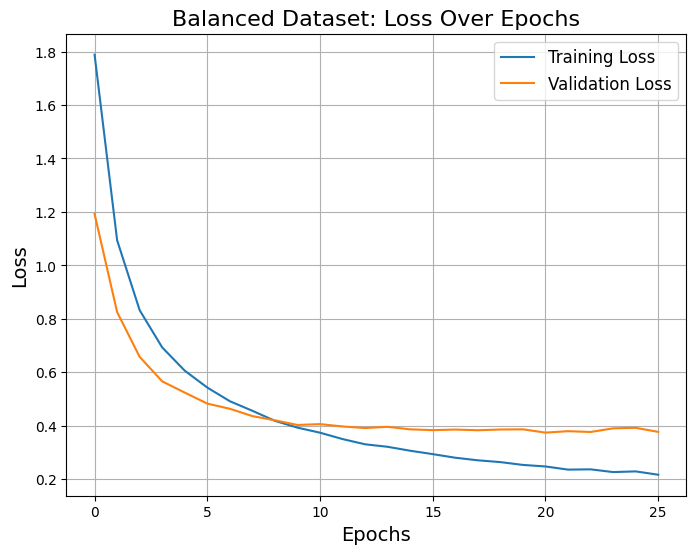

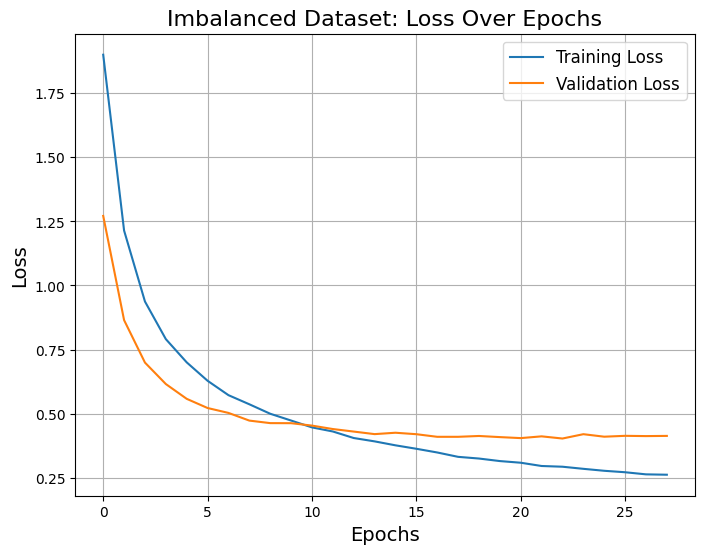

In [17]:
# WARNING: The cell takes about 3 minutes to run
# retrain the best model on the balanced and imbalanced dataset for reproducibile results

best_models_folder = 'best_models'
os.makedirs(best_models_folder, exist_ok=True)

balanced_fcn_model_path = os.path.join(best_models_folder, 'best_fcn_model_balanced.h5')
imbalanced_fcn_model_path = os.path.join(best_models_folder, 'best_fcn_model_imbalanced.h5')

early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True  
)

learning_rate = best_hyperparams.get('learning_rate')
adam_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Retrain the best model on the balanced dataset
best_model_balanced = tuner_bal.hypermodel.build(best_hyperparams)  # Build model with best hyperparameters
best_model_balanced.compile(
    optimizer=adam_optimizer,  # Use Adam optimizer with tuned learning rate
    loss='categorical_crossentropy',  # Assuming classification task
    metrics=['accuracy']  # Metrics to monitor
)
history_balanced = best_model_balanced.fit(
    X_train_bal_flat, y_train_bal_oh,  # Balanced training data
    validation_data=(X_val_bal_flat, y_val_bal_oh),  # Balanced validation data
    epochs=num_epochs, 
    callbacks=[early_stop],  # Early stopping callback
    verbose=1  
)
best_model_balanced.save(balanced_fcn_model_path)
print(f"Best model trained on the balanced dataset saved to '{balanced_fcn_model_path}'.\n")


# Retrain the best model on the imbalanced dataset
best_model_imbalanced = tuner_bal.hypermodel.build(best_hyperparams)  # Build model with best hyperparameters
best_model_imbalanced.compile(
    optimizer=adam_optimizer,  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)
history_imbalanced = best_model_imbalanced.fit(
    X_train_inbal_flat, y_train_inbal_oh,  # Imbalanced training data
    validation_data=(X_val_inbal_flat, y_val_inbal_oh),  # Imbalanced validation data
    epochs=num_epochs,  
    callbacks=[early_stop],  # Early stopping callback
    verbose=1  
)
best_model_imbalanced.save(imbalanced_fcn_model_path)
print(f"Best model trained on the imbalanced dataset saved to '{imbalanced_fcn_model_path}'.")

def plot_loss(history, dataset_type): # Function to plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_type} Dataset: Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot loss for both datasets
plot_loss(history_balanced, "Balanced")
plot_loss(history_imbalanced, "Imbalanced")


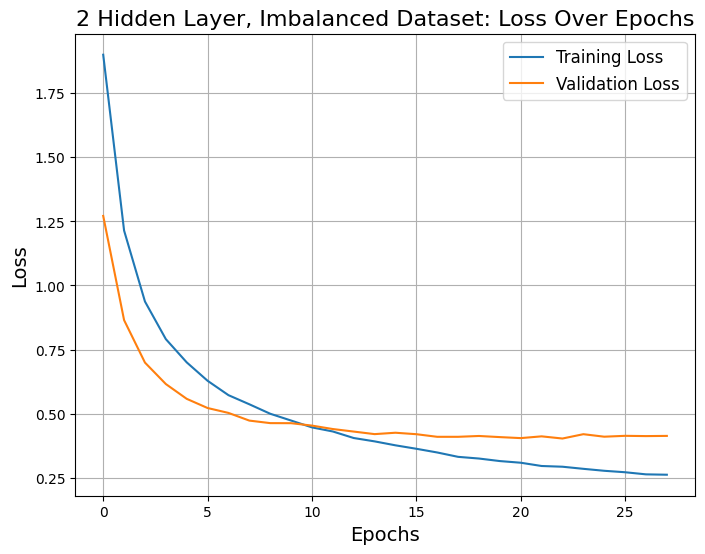

In [18]:

def plot_loss(history, dataset_type): # Function to plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'2 Hidden Layer, {dataset_type} Dataset: Loss Over Epochs', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Plot loss for both datasets
plot_loss(history_imbalanced, "Imbalanced")

In [19]:
# evaluate the best balanced and imbalanced model on the balanced and imbalanced test set

best_balanced_model = load_model(balanced_fcn_model_path)
best_imbalanced_model = load_model(imbalanced_fcn_model_path)

bal_model_on_bal_test = best_balanced_model.evaluate(X_test_bal_flat, y_test_bal_oh, verbose=1)
bal_model_on_inbal_test = best_balanced_model.evaluate(X_test_inbal_flat, y_test_inbal_oh, verbose=1)
inbal_model_on_bal_test = best_imbalanced_model.evaluate(X_test_bal_flat, y_test_bal_oh, verbose=1)
inbal_model_on_inbal_test = best_imbalanced_model.evaluate(X_test_inbal_flat, y_test_inbal_oh, verbose=1)

print("\nResults Summary:")
print(f"Balanced Model on Balanced Test Set: Loss = {bal_model_on_bal_test[0]:.4f}, Accuracy = {bal_model_on_bal_test[1]:.4f}")
print(f"Balanced Model on Imbalanced Test Set: Loss = {bal_model_on_inbal_test[0]:.4f}, Accuracy = {bal_model_on_inbal_test[1]:.4f}")
print(f"Imbalanced Model on Balanced Test Set: Loss = {inbal_model_on_bal_test[0]:.4f}, Accuracy = {inbal_model_on_bal_test[1]:.4f}")
print(f"Imbalanced Model on Imbalanced Test Set: Loss = {inbal_model_on_inbal_test[0]:.4f}, Accuracy = {inbal_model_on_inbal_test[1]:.4f}")


594/594 [==============================] - 1s 893us/step - loss: 0.4353 - accuracy: 0.8897

Results Summary:
Balanced Model on Balanced Test Set: Loss = 0.3832, Accuracy = 0.8979
Balanced Model on Imbalanced Test Set: Loss = 0.4478, Accuracy = 0.8835
Imbalanced Model on Balanced Test Set: Loss = 0.4390, Accuracy = 0.8912
Imbalanced Model on Imbalanced Test Set: Loss = 0.4353, Accuracy = 0.8897


594/594 [==============================] - 1s 770us/step


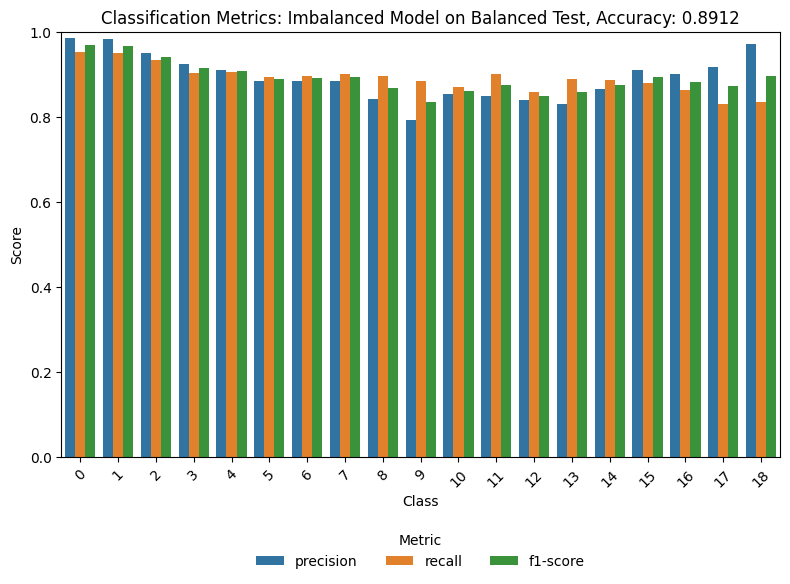

In [20]:
# plot the classification report on the balanced test set for the best model

y_pred = best_imbalanced_model.predict(X_test_bal_flat)
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test_bal, y_pred_classes , output_dict=True)

report_df = pd.DataFrame(report).transpose()

metrics_df = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])


metrics_melted = metrics_df.reset_index().melt(
    id_vars='index',
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)

metrics_melted.rename(columns={'index': 'Class'}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_melted)
plt.ylim(0, 1)
plt.title(f"Classification Metrics: Imbalanced Model on Balanced Test, Accuracy: {inbal_model_on_bal_test[1]:.4f}")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# since imbalanced dataset provides more information, we will use the imbalanced dataset for future training, 
# use balanced dataset for evaluation for better comparison

## Question 3. Random Forests and Support Vector Machine

In [22]:
# preparing the data for random forest and SVM

scaler = StandardScaler()

# Use imbalanced dataset for training, use balanced dataset for evaluation
X_train_rf = scaler.fit_transform(X_train_inbal_flat)
X_val_rf = scaler.transform(X_val_bal_flat)
X_test_rf = scaler.transform(X_test_bal_flat)

y_train_rf = y_train_inbal
y_val_rf = y_val_bal
y_test_rf = y_test_bal

In [23]:
# # WARNING: This Cell takes 3-5 minutes to run
# # hyperparameter tuning for random forest(on number of estimators)

# rf_tuning_results = [] # to store accuracy and hyperparameters of random forest models

# # Train Random Forest Classifier with different number of estimators
# for index, n_estimators in enumerate([50, 100, 200, 300, 500], start=1):
#     rf_tuning_params = {
#         'n_estimators': n_estimators,
#         'max_depth': None,
#         'min_samples_split': 2,
#         'min_samples_leaf': 1,
#         'max_features': 'sqrt',
#         'class_weight': 'balanced',
#         'random_state': RANDOM_SEED,
#         'n_jobs': 6
#     }

#     rf_tuning_clf = RandomForestClassifier(**rf_tuning_params)
#     rf_tuning_clf.fit(X_train_rf, y_train_rf)

#     # Evaluate the model on the validation set
#     y_pred_val_rf = rf_tuning_clf.predict(X_val_rf)
#     val_accuracy_rf = accuracy_score(y_val_rf, y_pred_val_rf)
#     print(f"Number of estimator: {n_estimators}, Validation Accuracy: {val_accuracy_rf:.4f}")
    
#     rf_tuning_results.append({
#     'n_estimators': n_estimators,
#     'max_depth': None,
#     'min_samples_split': 2,
#     'min_samples_leaf': 1,
#     'max_features': 'sqrt',
#     'class_weight': 'balanced',
#     'random_state': RANDOM_SEED,
#     'validation_accuracy': val_accuracy_rf,
#     })

# rf_tuning_output_file = 'random_forests_results.json'
# rf_tuning_results_path = os.path.join(results_folder, rf_tuning_output_file)
# with open(rf_tuning_results_path, 'w') as f:
#     json.dump(rf_tuning_results, f, indent=4)
# print(f"Model parameters and accuracies saved to {rf_tuning_results_path}\n")

In [24]:
# load hyperparameter tuning results from random foreset, print the accuracy 

rf_tuning_output_file = 'random_forests_results.json'
rf_tuning_results_path = os.path.join(results_folder, rf_tuning_output_file)

with open(rf_tuning_results_path, 'r') as f:
    rf_loaded_results = json.load(f)

# Print the number of estimators and performance
for rf_result in rf_loaded_results:
    print(f"Number of Estimators: {rf_result['n_estimators']}, Validation Accuracy: {rf_result['validation_accuracy']:.4f}")


Number of Estimators: 50, Validation Accuracy: 0.7115
Number of Estimators: 100, Validation Accuracy: 0.7465
Number of Estimators: 200, Validation Accuracy: 0.7661
Number of Estimators: 300, Validation Accuracy: 0.7734
Number of Estimators: 500, Validation Accuracy: 0.7802


In [25]:
# retrain best performing random forest model on the imbalanced dataset

best_n_estimators_rf = 500

rf_best_params = {
    'n_estimators': best_n_estimators_rf,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'class_weight': 'balanced',
    'random_state': RANDOM_SEED,
    'n_jobs': 6
}

rf_best_clf = RandomForestClassifier(**rf_best_params)
rf_best_clf.fit(X_train_rf, y_train_rf) # ploting classification report for random forest

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=6,
                       random_state=42)

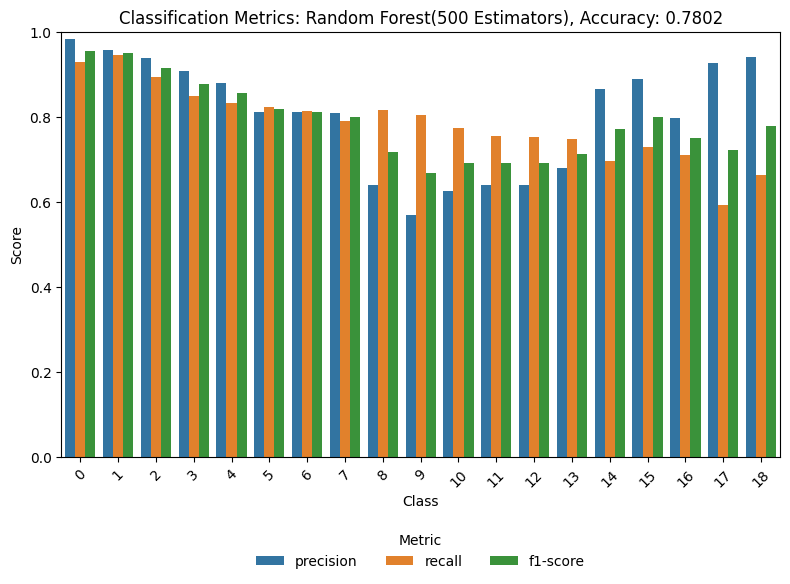

In [26]:
with open(rf_tuning_results_path, 'r') as f:
    rf_loaded_results = json.load(f)
rf_best_accuracy = rf_loaded_results[-1]['validation_accuracy']

y_pred_rf_test = rf_best_clf.predict(X_test_rf) 
rf_classification_report = classification_report(y_test_rf, y_pred_rf_test, output_dict=True)

rf_report_df = pd.DataFrame(rf_classification_report).transpose()
rf_metrics_df = rf_report_df.drop(['accuracy', 'macro avg', 'weighted avg'])

rf_metrics_melted = rf_metrics_df.reset_index().melt(
    id_vars='index',
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)
rf_metrics_melted.rename(columns={'index': 'Class'}, inplace=True)

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=rf_metrics_melted)
plt.ylim(0, 1)
plt.title(f"Classification Metrics: Random Forest(500 Estimators), Accuracy: {rf_best_accuracy:.4f}")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# # WARNING: This cell takes about 30 minutes to run
# # hyperparameter tuning for SVM (on kernel)

# svm_results = []

# # SVM is very slow to train, so I will use a small sample of the training data for hyperparameter tuning
# # I am aware that this is not the best practice, but it is necessary for the sake of time
# X_sample, _, y_sample, _ = train_test_split(X_train_rf, y_train_rf, test_size=0.8, random_state=42)

# kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# for kernel in kernels:

#     svm_clf = SVC(
#         kernel=kernel,
#         degree=3 if kernel == 'poly' else 0,  # set degree to 3 for polynomial kernel
#         C=1.0,
#         gamma='scale',
#         class_weight='balanced',
#         random_state=42)

#     svm_clf.fit(X_sample, y_sample)

#     y_pred_val = svm_clf.predict(X_val_rf)
#     val_accuracy = accuracy_score(y_val_rf, y_pred_val)

#     print(f"Kernel: {kernel}, SVM Validation Accuracy: {val_accuracy:.4f}")

#     svm_results.append({
#         "kernel": kernel,
#         "validation_accuracy": val_accuracy
#     })


# svm_output_file = "svm_trail_performance.json"
# svm_results_path = os.path.join(results_folder, svm_output_file)

# with open(svm_results_path, "w") as f:
#     json.dump(results, f, indent=4)

# print(f"Results saved to {svm_results_path}")

In [28]:
# print out the performance of SVM

svm_output_file = "svm_trail_performance.json"
svm_results_path = os.path.join(results_folder, svm_output_file)

with open(svm_results_path, "r") as f:
    svm_results = json.load(f)

for entry in svm_results:
    print(f"Kernel: {entry['kernel']}, Validation Accuracy: {entry['validation_accuracy']:.4f}")

Kernel: linear, Validation Accuracy: 0.3119
Kernel: poly, Validation Accuracy: 0.3755
Kernel: rbf, Validation Accuracy: 0.5301
Kernel: sigmoid, Validation Accuracy: 0.3413


In [29]:
# # WARNING: This cell takes 66 minutes to run 

# # Since the rbf kernel has the highest validation accuracy, we will use it for the final model
# # I have saved and will reload the model in the next cell

# # Train the SVM with rbf kernel on the full training data

# svm_clf = SVC(
#     kernel='rbf',
#     C=1.0,
#     gamma='scale',
#     class_weight='balanced',
#     random_state=RANDOM_SEED)

# svm_clf.fit(X_train_rf, y_train_rf)

# # Save the trained SVM model
# svm_model_file = 'svm_rbf_model.joblib'
# svm_model_path = os.path.join(best_models_folder, svm_model_file)

# dump(svm_clf, svm_model_path)
# print(f"SVM model saved to {svm_model_path}")

In [30]:
# # WARNING: This cell takes 20 minutes to run in my machine,
# # Load the trained SVM model and evaluate on the balanced test set. Save the evaluation results to a CSV file

# svm_model_file = 'svm_rbf_model.joblib'
# svm_model_path = os.path.join(best_models_folder, svm_model_file)
# svm_clf = load(svm_model_path)
# print(f"SVM model loaded from {svm_model_path}")

# # Evaluate the SVM model on the balanced test set
# y_pred_val = svm_clf.predict(X_val_rf)
# val_accuracy = accuracy_score(y_val_rf, y_pred_val)

# svm_report = classification_report(y_val_rf, y_pred_val, output_dict=True)
# report_df = pd.DataFrame(svm_report).transpose()

# svm_report_file = 'svm_report.csv'
# svm_report_path = os.path.join(results_folder, svm_report_file)
# report_df.to_csv(svm_report_path, index=True)

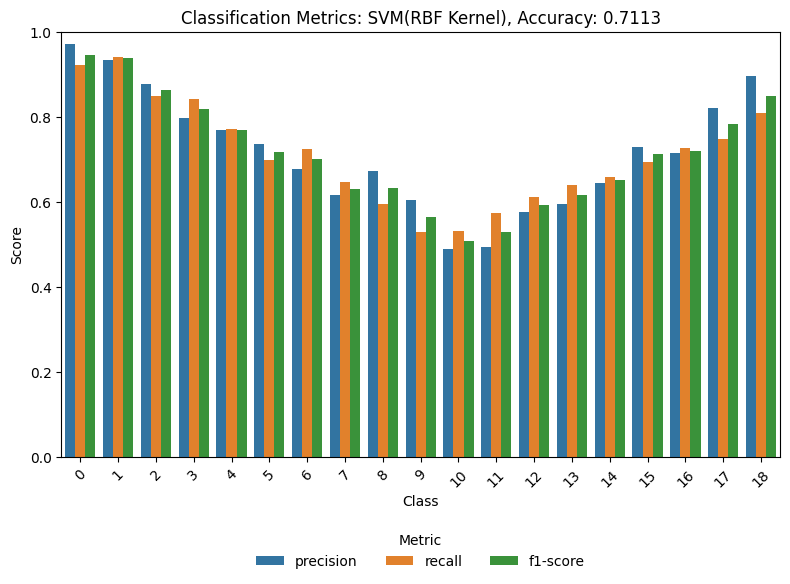

In [31]:
# plot the classification report for SVM

svm_report_file = 'svm_report.csv'
svm_report_path = os.path.join(results_folder, svm_report_file)
svm_report_df = pd.read_csv(svm_report_path)

metrics_df = svm_report_df.loc['0':'18', ['precision', 'recall', 'f1-score']]

metrics_melted = metrics_df.reset_index().melt(
    id_vars='index',
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)
metrics_melted.rename(columns={'index': 'Class'}, inplace=True)

svm_accuracy = svm_report_df.loc[svm_report_df['Unnamed: 0'] == 'accuracy', 'precision'].values[0]
# print(f"SVM Accuracy: {svm_accuracy:.4f}")

plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_melted)
plt.ylim(0, 1)
plt.title(f"Classification Metrics: SVM(RBF Kernel), Accuracy: {svm_accuracy:.4f}")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q4. Weak linear classifier on combined images and on separated images


In [32]:
def split_and_flatten_images(images):
    """
    Splits images into upper and lower halves and flattens them.
    Args:
        images (numpy.ndarray): Array of images (shape: [num_samples, 56, 28]).
    Returns:
        upper_flat (numpy.ndarray): Flattened upper halves (shape: [num_samples, 784]).
        lower_flat (numpy.ndarray): Flattened lower halves (shape: [num_samples, 784]).
    """
    
    upper_images = images[:, :28, :]  
    lower_images = images[:, 28:, :]  
    
    upper_flat = upper_images.reshape(images.shape[0], -1)
    lower_flat = lower_images.reshape(images.shape[0], -1)
    
    return upper_flat, lower_flat

upper, lower = split_and_flatten_images(X_train_inbal)

In [ ]:
# Method1, train on the full image

sample_sizes = [50, 100, 500, 1000, 2000, 5000, 10000, 20000]

results_method1 = []


print('Method 1\n')
for sample_size in sample_sizes:
    print(f"Sample Size: {sample_size}")
    
    # sampling from imbalanced dataset
    indices = np.random.choice(len(X_train_inbal_flat), size=sample_size, replace=False)
    X_train_sample_flat = X_train_inbal_flat[indices]
    y_train_sample = y_train_inbal[indices]  
    
    scaler1 = StandardScaler()
    X_train_sample_scaled = scaler1.fit_transform(X_train_sample_flat)
    X_val_scaled = scaler1.transform(X_val_bal_flat)  
    
    clf1 = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    clf1.fit(X_train_sample_scaled, y_train_sample)
    
    y_val_pred1 = clf1.predict(X_val_scaled)
    accuracy_val1 = accuracy_score(y_val_bal, y_val_pred1)
    print(f"Accuracy: {accuracy_val1:.4f}\n")
    results_method1.append((sample_size, accuracy_val1))

Method 1

Sample Size: 50
Accuracy: 0.0934

Sample Size: 100
Accuracy: 0.1087

Sample Size: 500
Accuracy: 0.1430

Sample Size: 1000
Accuracy: 0.1483

Sample Size: 2000
Accuracy: 0.1602

Sample Size: 5000
Accuracy: 0.1661

Sample Size: 10000
Accuracy: 0.2032

Sample Size: 20000


In [ ]:
# Use 1 classifier for upper half and 1 classifier for lower half, 
# Train on imbalanced data(doesn't matter here), evaluated on balanced data

# split and flatten validation images for validation data(Balanced)
upper_val, lower_val = split_and_flatten_images(X_val_bal)

results_method2 = []

print('Method 2\n')
for sample_size in sample_sizes:
    print(f"Sample Size：{sample_size}")
    
    # Sample from the imbalanced training set
    indices = np.random.choice(len(X_train_inbal), size=sample_size, replace=False)
    X_train_sample_images = X_train_inbal[indices]
    y_train_sample_2labels = y_train_2labels_inbal[indices]
    
    # split and flatten training images for training data
    upper_train, lower_train = split_and_flatten_images(X_train_sample_images) 

    # Combine the training data for fitting the scaler
    combined_train = np.concatenate((upper_train, lower_train), axis=0)
    scaler = StandardScaler()
    scaler.fit(combined_train)
    
    # Fit and transform the training and validation data
    upper_train_scaled = scaler.transform(upper_train)
    lower_train_scaled = scaler.transform(lower_train)
    upper_val_scaled = scaler.transform(upper_val)
    lower_val_scaled = scaler.transform(lower_val)
    
    # Train the upper and lower half classifiers
    clf_upper = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    clf_upper.fit(upper_train_scaled, y_train_sample_2labels[:, 0])
    clf_lower = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    clf_lower.fit(lower_train_scaled, y_train_sample_2labels[:, 1])
    
    # Individual predictions on validation set
    y_val_pred_upper = clf_upper.predict(upper_val_scaled)
    y_val_pred_lower = clf_lower.predict(lower_val_scaled)
    
    
    y_val_pred2 = y_val_pred_upper + y_val_pred_lower # Combine the predictions
    
    accuracy_val2 = accuracy_score(y_val_bal, y_val_pred2)
    print(f"Accuracy: {accuracy_val2:.4f}\n")
    results_method2.append((sample_size, accuracy_val2))


## Q5. t-SNE for embedding layer and for input dataset

In [ ]:
# t-SNE visualization of the embedding layer outputs

best_model_path = 'best_model_imbalanced.h5'
model = load_model(best_model_path)

embedding_layer = model.layers[-2]
embedding_model = tf.keras.Model(inputs=model.input, outputs=embedding_layer.output)
print(f"Embedding layer output shape: {embedding_layer.output_shape}")

num_samples = 5000  

# Sample from the imbalanced training set
indices = np.random.choice(len(X_train_inbal_flat), size=num_samples, replace=False)
X_sample = X_train_inbal_flat[indices]
y_sample = y_train_inbal[indices]

# output of the embedding layer
embedding_outputs = embedding_model.predict(X_sample)
print(f"Embedding outputs shape: {embedding_outputs.shape}")


perplexities = [5, 30, 50, 100]  

best_perplexity = None
best_embedding = None
min_kl_divergence = np.inf

for perplexity in perplexities:
    print(f"Applying t-SNE with perplexity={perplexity} on embedding outputs...")
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, verbose=1)
    embedding_tsne = tsne.fit_transform(embedding_outputs)
    kl_divergence = tsne.kl_divergence_
    print(f"KL divergence: {kl_divergence}")
    
    if kl_divergence < min_kl_divergence:
        min_kl_divergence = kl_divergence
        best_perplexity = perplexity
        best_embedding = embedding_tsne

print(f"Best perplexity for embedding outputs: {best_perplexity}")

tsne_df = pd.DataFrame({
    'TSNE-1': best_embedding[:, 0],
    'TSNE-2': best_embedding[:, 1],
    'Label': y_sample
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label',
    palette=sns.color_palette('hls', len(np.unique(y_sample))),
    data=tsne_df,
    legend='full',
    alpha=0.6
)
plt.title(f"t-SNE on Embedding Layer Outputs (Perplexity={best_perplexity})")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# t-SNE on input data

perplexities = [5, 30, 50, 100]  

best_perplexity_input = None
best_embedding_input = None
min_kl_divergence_input = np.inf

for perplexity in perplexities:
    print(f"Applying t-SNE with perplexity={perplexity} on input data...")
    tsne_input = TSNE(n_components=2, perplexity=perplexity, random_state=42, verbose=1)
    input_tsne = tsne_input.fit_transform(X_sample)
    kl_divergence = tsne_input.kl_divergence_
    print(f"KL divergence: {kl_divergence}")
    
    if kl_divergence < min_kl_divergence_input:
        min_kl_divergence_input = kl_divergence
        best_perplexity_input = perplexity
        best_embedding_input = input_tsne

print(f"Best perplexity for input data: {best_perplexity_input}")


tsne_input_df = pd.DataFrame({
    'TSNE-1': best_embedding_input[:, 0],
    'TSNE-2': best_embedding_input[:, 1],
    'Label': y_sample
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Label',
    palette=sns.color_palette('hls', len(np.unique(y_sample))),
    data=tsne_input_df,
    legend='full',
    alpha=0.6
)
plt.title(f"t-SNE on Input Data (Perplexity={best_perplexity_input})")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

